In [1]:
# import the libraries you need, make sure they are installed within your Python env
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import missingno as msno
from scipy.stats import skew, norm, ttest_ind
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn import linear_model
#import sklearn.model_selection as ms
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold,cross_val_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# the following code ensures that you can see your (print) results for multiple tasks within a coding block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


pd.options.display.width = None


In [78]:

london_data = pd.read_csv("./data/london_listings.csv")
paris_data = pd.read_csv("./data/paris_listings.csv")
newyork_data = pd.read_csv("./data/newyork_listings.csv")

london_data['city'] = 0
paris_data['city'] = 1
newyork_data['city'] = 2

all_data = pd.concat([london_data, paris_data, newyork_data])

selected_attributes = ['city', 'host_since', 'host_response_time', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 
                       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 'accommodates', 
                       'bathrooms_text', 'beds', 'price', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
                       'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                       'review_scores_value', 'instant_bookable', 'reviews_per_month']

all_data = all_data[selected_attributes]
nan_count = all_data.isna().sum()
print(nan_count)
all_data = all_data.dropna()

# Changing host_since to years_hosted
all_data['years_hosted'] = 2023 - all_data['host_since'].str[:4].astype(int)
all_data = all_data.drop(columns='host_since')

print(all_data.dtypes)


city                               0
host_since                        19
host_response_time             78652
host_acceptance_rate           62047
host_is_superhost                280
host_listings_count               19
host_has_profile_pic              19
host_identity_verified            19
neighbourhood_cleansed             0
property_type                      0
accommodates                       0
bathrooms_text                   215
beds                           16806
price                          26336
availability_365                   0
number_of_reviews                  0
review_scores_rating           53351
review_scores_accuracy         53403
review_scores_cleanliness      53382
review_scores_checkin          53450
review_scores_communication    53401
review_scores_location         53452
review_scores_value            53456
instant_bookable                   0
reviews_per_month              53514
dtype: int64
city                             int64
host_response_time     

In [79]:
# Removing $ and , from price
all_data['price'] = all_data['price'].replace('[\$\,\.00]', '', regex=True).astype(int)
print(all_data['price'])

# Change host_acceptance_rate to float
all_data['host_acceptance_rate'] = all_data['host_acceptance_rate'].str[:-1].astype(float) / 100
print(all_data['host_acceptance_rate'])

0         67
2         65
4        149
6         52
8         41
        ... 
39183     15
39184     65
39192     37
39200     23
39201    175
Name: price, Length: 95384, dtype: int64
0        0.75
2        1.00
4        0.85
6        0.90
8        0.88
         ... 
39183    0.36
39184    0.93
39192    0.88
39200    0.50
39201    0.78
Name: host_acceptance_rate, Length: 95384, dtype: float64


<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
/var/folders/fm/q7jtdtbs4t15jc22wbnp83gh0000gn/T/ipykernel_97698/4110717217.py:2: SyntaxWarning: invalid escape sequence '\$'
  all_data['price'] = all_data['price'].replace('[\$\,\.00]', '', regex=True).astype(int)


In [80]:
print(all_data['host_response_time'].value_counts())
all_data['host_response_time'] = all_data['host_response_time'].map({'within an hour': 1, 'within a few hours': 2, 'within a day': 3, 'a few days or more': 4})
print(all_data['host_response_time'].value_counts())

host_response_time
within an hour        62867
within a few hours    17765
within a day          11850
a few days or more     2902
Name: count, dtype: int64
host_response_time
1    62867
2    17765
3    11850
4     2902
Name: count, dtype: int64


In [81]:
# Change t/f to bool
all_data['host_is_superhost'] = all_data['host_is_superhost'].replace({'t': True, 'f': False})
all_data['host_has_profile_pic'] = all_data['host_has_profile_pic'].replace({'t': True, 'f': False})
all_data['host_identity_verified'] = all_data['host_identity_verified'].replace({'t': True, 'f': False})
all_data['instant_bookable'] = all_data['instant_bookable'].replace({'t': True, 'f': False})
print(all_data['host_has_profile_pic'].dtypes)
print(all_data['host_identity_verified'].dtypes)
print(all_data['instant_bookable'].dtypes)
print(all_data['host_is_superhost'].dtypes)

bool
bool
bool
bool


In [82]:
dummy_neighbourhood = pd.get_dummies(all_data['neighbourhood_cleansed'])
dummy_property = pd.get_dummies(all_data['property_type'])
dummy_bathrooms = pd.get_dummies(all_data['bathrooms_text'])

all_data = pd.concat([all_data, dummy_neighbourhood, dummy_property, dummy_bathrooms], axis=1)
all_data.drop(columns=['neighbourhood_cleansed', 'property_type', 'bathrooms_text'], inplace=True)


<Figure size 1200x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap')

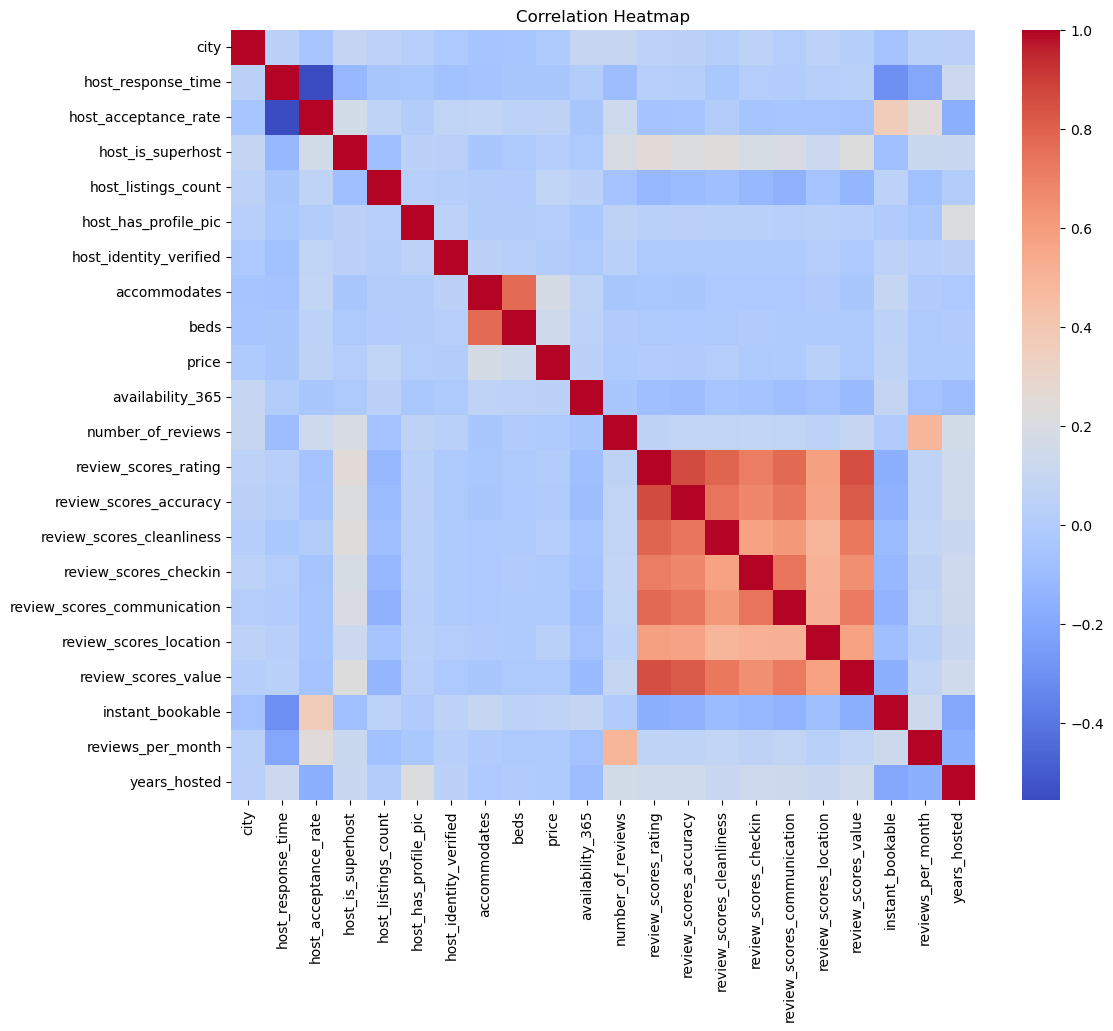

In [83]:
# Exclude the dummy variables from the correlation matrix
correlation_matrix = all_data.drop(columns=dummy_neighbourhood.columns.tolist() + dummy_property.columns.tolist() + dummy_bathrooms.columns.tolist()).corr()

# Create the heat map
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()




<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='city', ylabel='price'>

Text(0.5, 0, 'City')

Text(0, 0.5, 'Price')

Text(0.5, 1.0, 'Price Distribution by City')

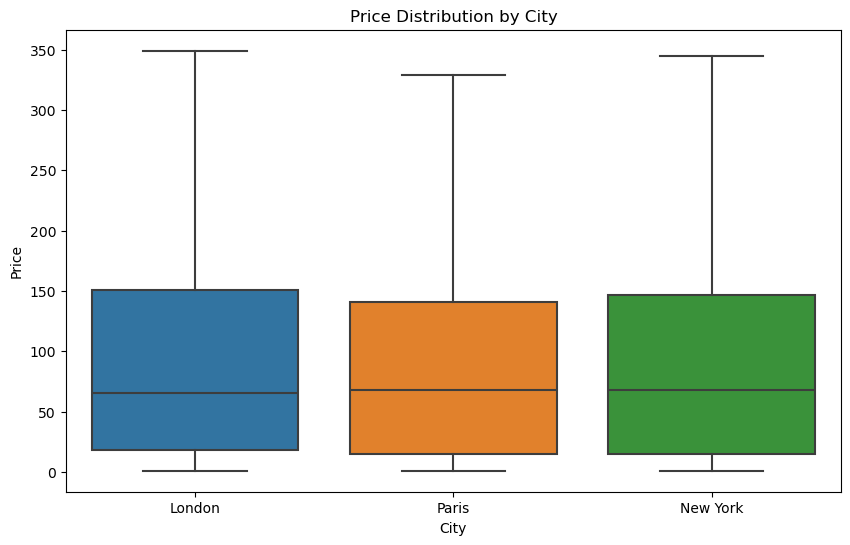

In [84]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=all_data['city'].map(city_names), y='price', data=all_data, showfliers=False)
plt.xlabel('City')
plt.ylabel('Price')
plt.title('Price Distribution by City')


In [85]:
all_data.groupby('city').describe()

host_response_time                                               \
                  count      mean       std  min  25%  50%  75%  max   
city                                                                   
0               47087.0  1.475354  0.796116  1.0  1.0  1.0  2.0  4.0   
1               35239.0  1.588552  0.859165  1.0  1.0  1.0  2.0  4.0   
2               13058.0  1.539746  0.819923  1.0  1.0  1.0  2.0  4.0   

     host_acceptance_rate            ... reviews_per_month         \
                    count      mean  ...               75%    max   
city                                 ...                            
0                 47087.0  0.866574  ...              1.75  48.59   
1                 35239.0  0.837510  ...              2.01  45.85   
2                 13058.0  0.847929  ...              2.01  78.25   

     years_hosted                                                
            count      mean       std  min  25%  50%  75%   max  
city                                                             
0         47087.0  6.006031  3.455656  0.0  3.0  7.0  9.0  15.0  
1         35239.0  6.508613  3.428161  0.0  4.0  7.0  9.0  15.0  
2         13058.0  6.138995  3.549481 -1.0  3.0  6.0  9.0  15.0  

[3 rows x 136 columns]